## 1. 檢查 GPU
首先確定我們可以使用 GPU。我們可以使用 nvidia-smi 命令來檢查。如果出現錯誤訊息，請前往「編輯」->「筆記本設定」->「硬體加速器」，將其設置為 GPU，然後點擊保存。

In [1]:
!nvidia-smi

Sun Jun  2 06:00:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 2. 訓練自己的 YOLOv10 模型
### 2.1 下載/安裝 YOLOv10

In [2]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 29.4 MB/s eta 0:00:00


### 2.2 下載權重
YOLOv10 已經在 coco 數據集上訓練過，該數據集包含 80 個可預測的類別。我們將獲取這些預訓練權重，以便可以在這些預訓練類別上運行物件辨識。您可以從以下連結查看預訓練的 YOLOv10 權重可以檢測到哪些類別。

- [COCO CLASSES](http://cocodataset.org/#explore)

| Model | Test Size | #Params | FLOPs | AP<sup>val</sup> | Latency |
|:---------------|:----:|:---:|:--:|:--:|:--:|
| [YOLOv10-N](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt) |   640  |     2.3M    |   6.7G   |     38.5%     | 1.84ms |
| [YOLOv10-S](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt) |   640  |     7.2M    |   21.6G  |     46.3%     | 2.49ms |
| [YOLOv10-M](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt) |   640  |     15.4M   |   59.1G  |     51.1%     | 4.74ms |
| [YOLOv10-B](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt) |   640  |     19.1M   |  92.0G |     52.5%     | 5.74ms |
| [YOLOv10-L](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt) |   640  |     24.4M   |  120.3G   |     53.2%     | 7.28ms |
| [YOLOv10-X](https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt) |   640  |     29.5M    |   160.4G   |     54.4%     | 10.70ms |


In [3]:
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!wget -P /content/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt

### 2.3 使用 Roboflow 匯入資料集

In [6]:
!pip install roboflow -q

In [7]:
from roboflow import Roboflow
rf = Roboflow(api_key="8Z4ck3hgIdLkrbFet3Yj")
project = rf.workspace("yolo-zbpxw").project("screw-fmzbb")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to screw-4 in yolov8:: 100%|██████████| 122/122 [00:00<00:00, 7022.26it/s]


**NOTE:**
Make sure the last 4 lines of the data.yaml file have the following format:

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

If using a dataset from Roboflow Universe, run the command below. 👇🏻

In [8]:
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

### 2.4 訓練模型

In [9]:
from ultralytics import YOLO

model = YOLO('/content/weights/yolov10l.pt')

results = model.train(data=f"{dataset.location}/data.yaml", epochs=50, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10l.pt, data=/content/screw-4/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

100%|██████████| 755k/755k [00:00<00:00, 14.9MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1    137728  ultralytics.nn.modules.block.SCDown          [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1    268800  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 79.8MB/s]
Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


AMP: checks passed ✅


train: Scanning /content/screw-4/train/labels... 48 images, 0 backgrounds, 0 corrupt: 100%|██████████| 48/48 [00:00<00:00, 1202.92it/s]

train: New cache created: /content/screw-4/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /content/screw-4/valid/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 1124.84it/s]

val: New cache created: /content/screw-4/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 167 weight(decay=0.0), 180 weight(decay=0.0005), 179 bias(decay=0.0)
TensorBoard: WARNING ⚠️ TensorBoard graph visualization failure 
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/50      14.8G      1.693       4.16      1.645      1.682       10.5      1.541         37        640: 100%|██████████| 3/3 [00:04<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

                   all          5         11    0.00943      0.292      0.145      0.115



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/50      14.8G      1.495      4.635      1.597      1.419      13.31      1.503         35        640: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all          5         11     0.0207      0.333       0.15      0.118



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/50      14.8G      1.731      4.368      1.678      1.627       11.1      1.569         33        640: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all          5         11     0.0235      0.333     0.0978     0.0762



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/50      14.9G      1.912      3.675      1.901      1.691      10.07      1.683         40        640: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all          5         11     0.0806       0.75      0.281      0.256



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/50      15.1G      1.662      2.952      1.553      1.531      8.123      1.411         30        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all          5         11      0.286      0.333       0.39      0.251



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/50      15.1G      1.661      2.741      1.547      1.415      7.134      1.386         29        640: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all          5         11      0.857       0.47      0.613      0.345



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/50      15.1G      1.581      2.469      1.551      1.464      5.739      1.442         30        640: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all          5         11      0.668      0.407      0.707      0.395



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/50      15.1G      1.805      2.968      1.572      1.735      5.643      1.505         42        640: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all          5         11      0.897      0.271      0.467      0.254



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/50      15.1G      1.452      2.165      1.363      1.529      4.528      1.336         45        640: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all          5         11      0.767      0.644      0.795      0.474



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/50      15.1G      1.612      2.169      1.542      1.654      4.734      1.483         34        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all          5         11      0.797      0.312       0.53      0.236



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      11/50      15.1G      1.576      1.833      1.469      1.575      3.593      1.448         29        640: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all          5         11      0.648       0.25      0.503      0.269



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      12/50      15.1G      1.791      1.868      1.717      1.922      3.794      1.742         22        640: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all          5         11      0.706      0.527      0.609      0.359



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      13/50      15.1G      1.851      1.784      1.716      1.865      2.962      1.616         60        640: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all          5         11      0.493      0.188       0.32      0.172



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      14/50      15.1G      1.658      1.904       1.51      1.722      2.805       1.53         49        640: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all          5         11      0.495       0.25      0.375      0.204



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      15/50      15.1G      1.589      1.723      1.453      1.725       2.45       1.47         32        640: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all          5         11      0.699      0.405      0.687      0.458



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      16/50      15.1G      1.584      1.658      1.493      1.665      2.281      1.494         45        640: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all          5         11      0.343      0.938      0.502      0.295



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      17/50      15.1G      1.748      2.032      1.584      1.698      2.652      1.513         37        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all          5         11      0.521      0.706       0.86      0.549



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      18/50      15.1G      1.775      2.146      1.794      1.689      2.601      1.726         38        640: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all          5         11      0.416      0.867      0.703      0.443



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      19/50      15.1G      1.625      1.735      1.488      1.764      2.219      1.535         38        640: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all          5         11      0.263       0.66      0.546      0.343



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      20/50      15.1G       1.52      1.351      1.386      1.632      1.769      1.358         35        640: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all          5         11      0.476      0.333      0.531       0.36



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      21/50      15.1G      1.656      1.591       1.65      1.712      2.042      1.547         39        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all          5         11      0.264      0.418      0.393      0.203



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      22/50      15.1G      1.658      1.505      1.455      1.672      1.802      1.403         28        640: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all          5         11      0.344      0.568      0.486      0.307



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      23/50      15.1G       1.52      1.471      1.447       1.63      1.851      1.462         43        640: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all          5         11      0.375      0.597      0.493      0.308



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      24/50      15.1G      1.435      1.493      1.439      1.613      1.852      1.514         31        640: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all          5         11      0.636      0.488      0.633      0.368



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      25/50      15.1G      1.519      1.507      1.375      1.575      1.724      1.372         29        640: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all          5         11      0.556      0.875      0.854      0.505



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      26/50      15.1G       1.36      1.247      1.291      1.557      1.263      1.327         32        640: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]

                   all          5         11      0.279      0.435       0.46      0.245



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      27/50      15.1G      1.518      1.332      1.414       1.49       1.57      1.353         41        640: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all          5         11      0.273      0.521      0.289      0.127



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      28/50      15.1G      1.592      1.339       1.59      1.689      1.557      1.582         42        640: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all          5         11      0.498      0.579      0.603      0.363



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      29/50      15.1G      1.595      1.273      1.453      1.646      1.762      1.426         53        640: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all          5         11      0.498      0.579      0.603      0.363



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      30/50      15.1G      1.649       1.41      1.442      1.855      1.549       1.49         42        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all          5         11      0.324      0.392      0.373      0.204



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      31/50      15.1G      1.492      1.308      1.456      1.598      1.543      1.408         33        640: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all          5         11      0.509      0.569      0.552      0.336



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      32/50      15.1G      1.514      1.341      1.535      1.636      1.607      1.541         37        640: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all          5         11      0.651      0.701      0.699      0.451



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      33/50      15.1G      1.437      1.099      1.409       1.49      1.335      1.413         34        640: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all          5         11      0.651      0.701      0.699      0.451



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      34/50      15.1G      1.479      1.269      1.346      1.466      1.489      1.293         26        640: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all          5         11      0.551      0.634      0.668      0.442



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      35/50      15.1G       1.64      1.319      1.428      1.719      1.516      1.429         35        640: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all          5         11      0.444      0.583      0.572      0.328



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      36/50      15.1G      1.476      1.198      1.442       1.61      1.412      1.482         37        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all          5         11      0.353      0.672      0.534      0.333



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      37/50      15.1G      1.477      1.294      1.495      1.557      1.427      1.523         43        640: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all          5         11      0.353      0.672      0.534      0.333



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      38/50      15.1G      1.629      1.229      1.531      1.602      1.416      1.495         32        640: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all          5         11      0.589      0.542      0.665      0.416



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      39/50      15.1G      1.462      1.336      1.428      1.549      1.527       1.42         30        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all          5         11      0.625      0.637      0.576      0.357



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      40/50      15.1G       1.59      1.256      1.439       1.65      1.552      1.479         32        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all          5         11      0.637      0.625      0.511      0.302


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      41/50      15.1G      1.246       1.06      1.266      1.339      1.288       1.26         16        640: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all          5         11      0.637      0.625      0.511      0.302



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      42/50      15.1G      1.367       1.04      1.446      1.462      1.254      1.462         21        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all          5         11      0.668      0.588      0.535      0.347



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      43/50      15.1G      1.371      1.198      1.467      1.441      1.367      1.466         19        640: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all          5         11      0.804      0.667      0.837      0.508



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      44/50      15.1G      1.388      1.001      1.422       1.47       1.18      1.408         27        640: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all          5         11      0.654      0.972      0.854      0.628



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      45/50      15.1G      1.256     0.9504      1.345      1.272      1.222      1.389         22        640: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all          5         11      0.654      0.972      0.854      0.628



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      46/50      15.1G      1.281     0.9379      1.314      1.403       1.08      1.382         18        640: 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all          5         11      0.694      0.941      0.874       0.61



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      47/50      15.1G      1.299      0.954      1.424      1.399       1.04      1.448         26        640: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          5         11       0.63      0.615      0.728      0.522



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      48/50      15.1G      1.457     0.9851      1.537      1.458      1.205      1.521         30        640: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all          5         11      0.764      0.636      0.746      0.518



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      49/50      15.1G      1.399     0.9509        1.3      1.439      1.073      1.309         16        640: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all          5         11      0.764      0.636      0.746      0.518



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      50/50      15.1G       1.26     0.8498      1.376      1.387      1.012      1.417         26        640: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          5         11      0.549      0.765       0.76       0.56



50 epochs completed in 0.100 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10l summary (fused): 461 layers, 25722536 parameters, 0 gradients, 126.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


                   all          5         11      0.655      0.976      0.854      0.615
                class1          5          2      0.884          1      0.995       0.71
                class2          5          2      0.327          1      0.695      0.657
                class3          5          3      0.726      0.905       0.83      0.626
                class4          5          4      0.683          1      0.895      0.467
Speed: 1.0ms preprocess, 46.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train


In [10]:
## 亦可使用 CLI 指令進行模型訓練(Ultralytics API)
# !yolo task=detect mode=train epochs=100 batch=16 plots=True \
# model=/content/weights/yolov10n.pt \
# data={dataset.location}/data.yaml

### 2.5 評估模型

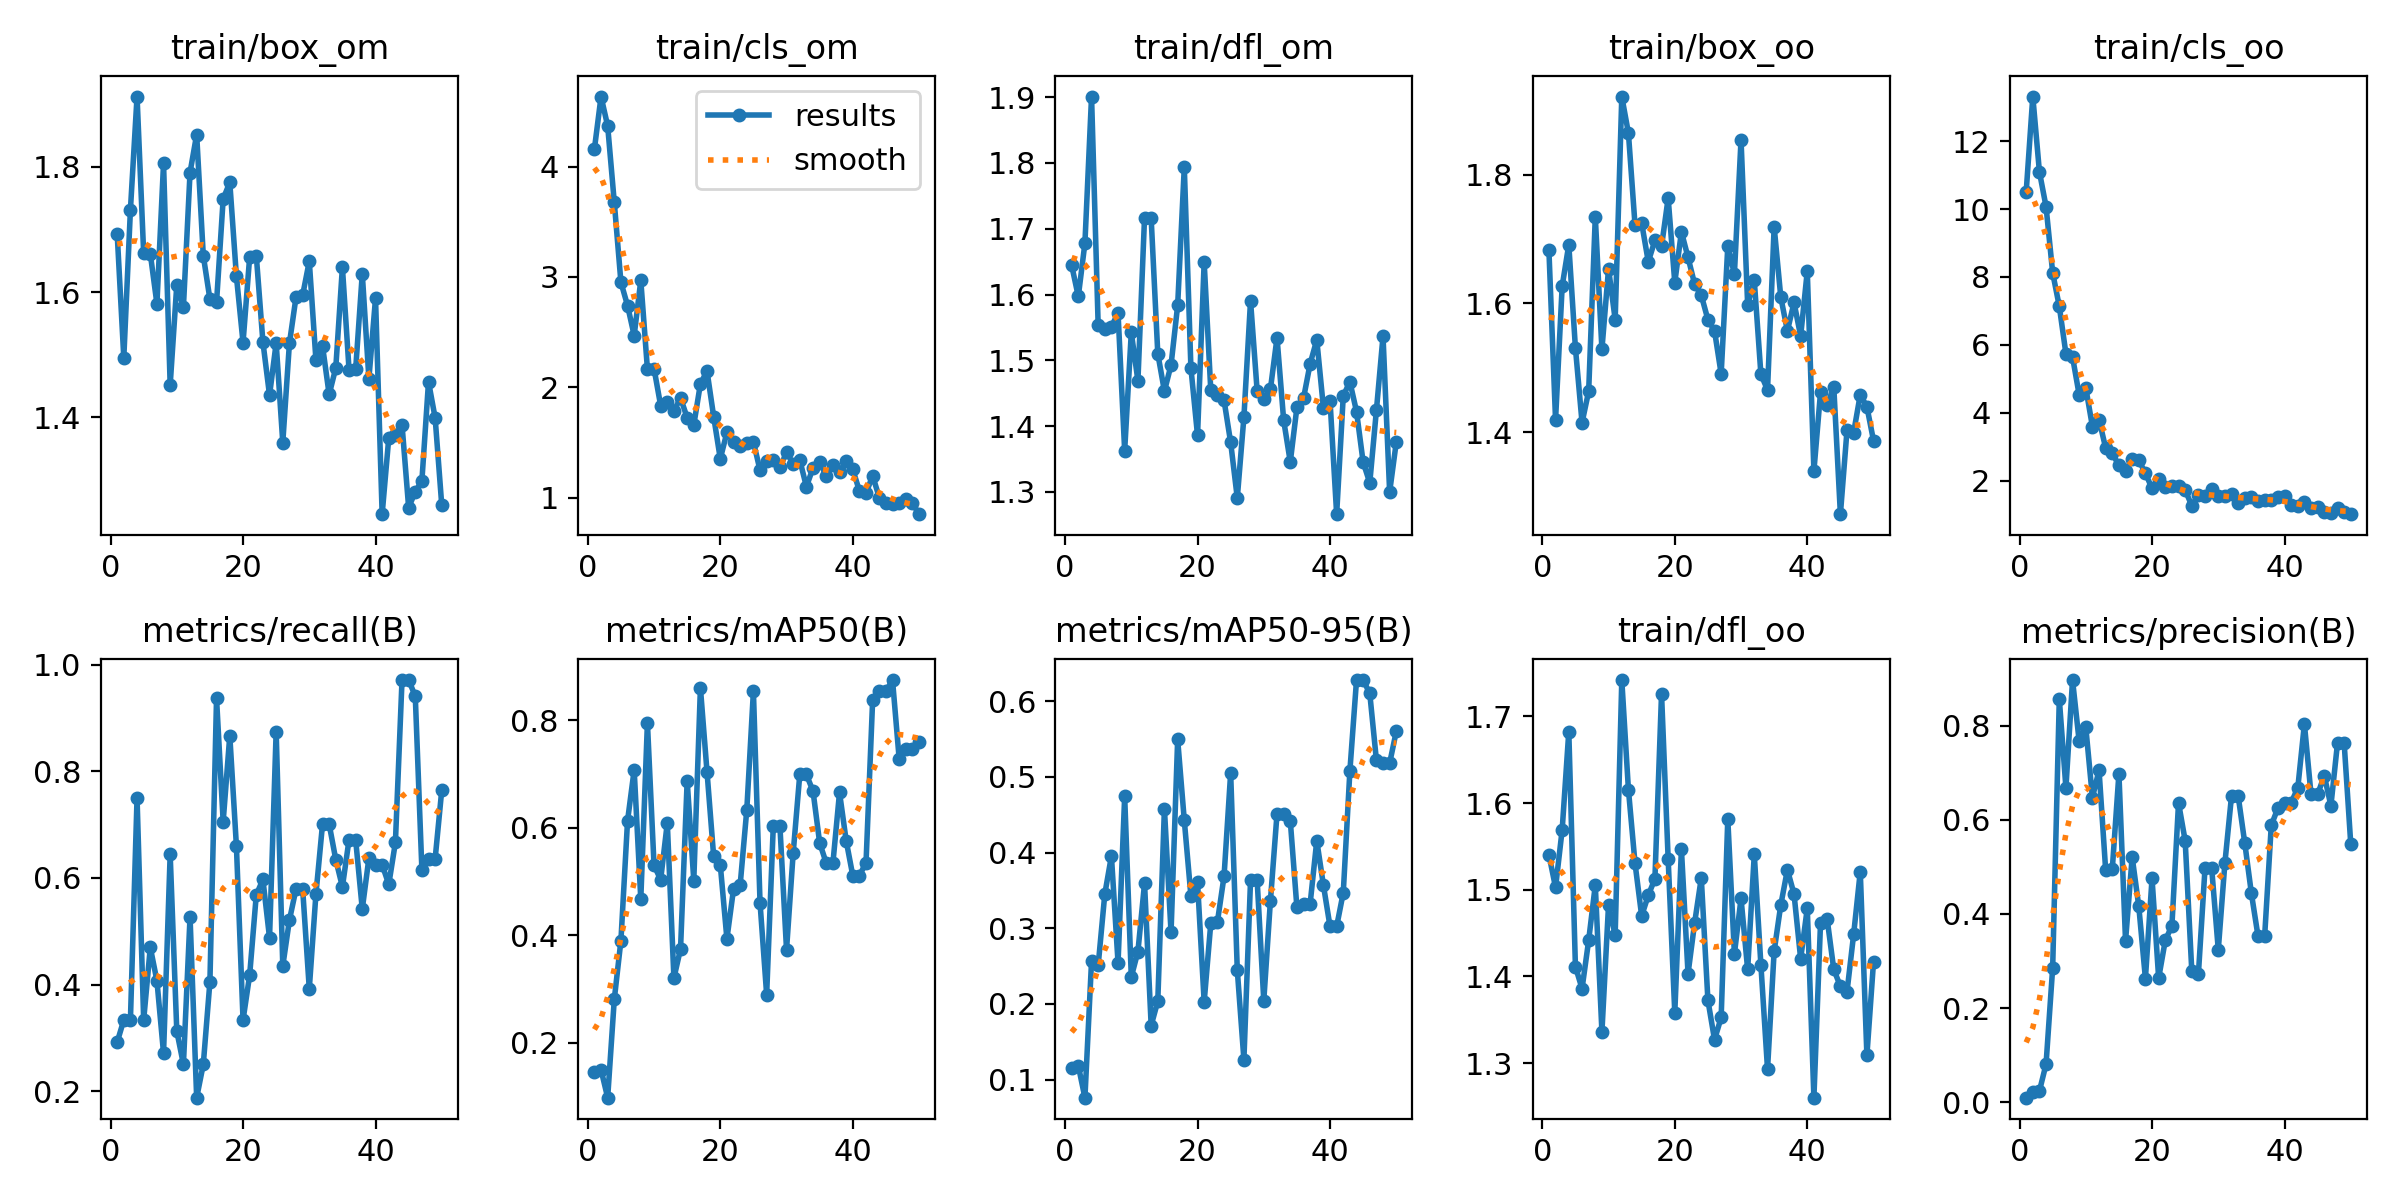

In [11]:
from IPython.display import Image

# 顯示訓練結果loss
Image(filename=f"/content/runs/detect/train/results.png", width=1000)

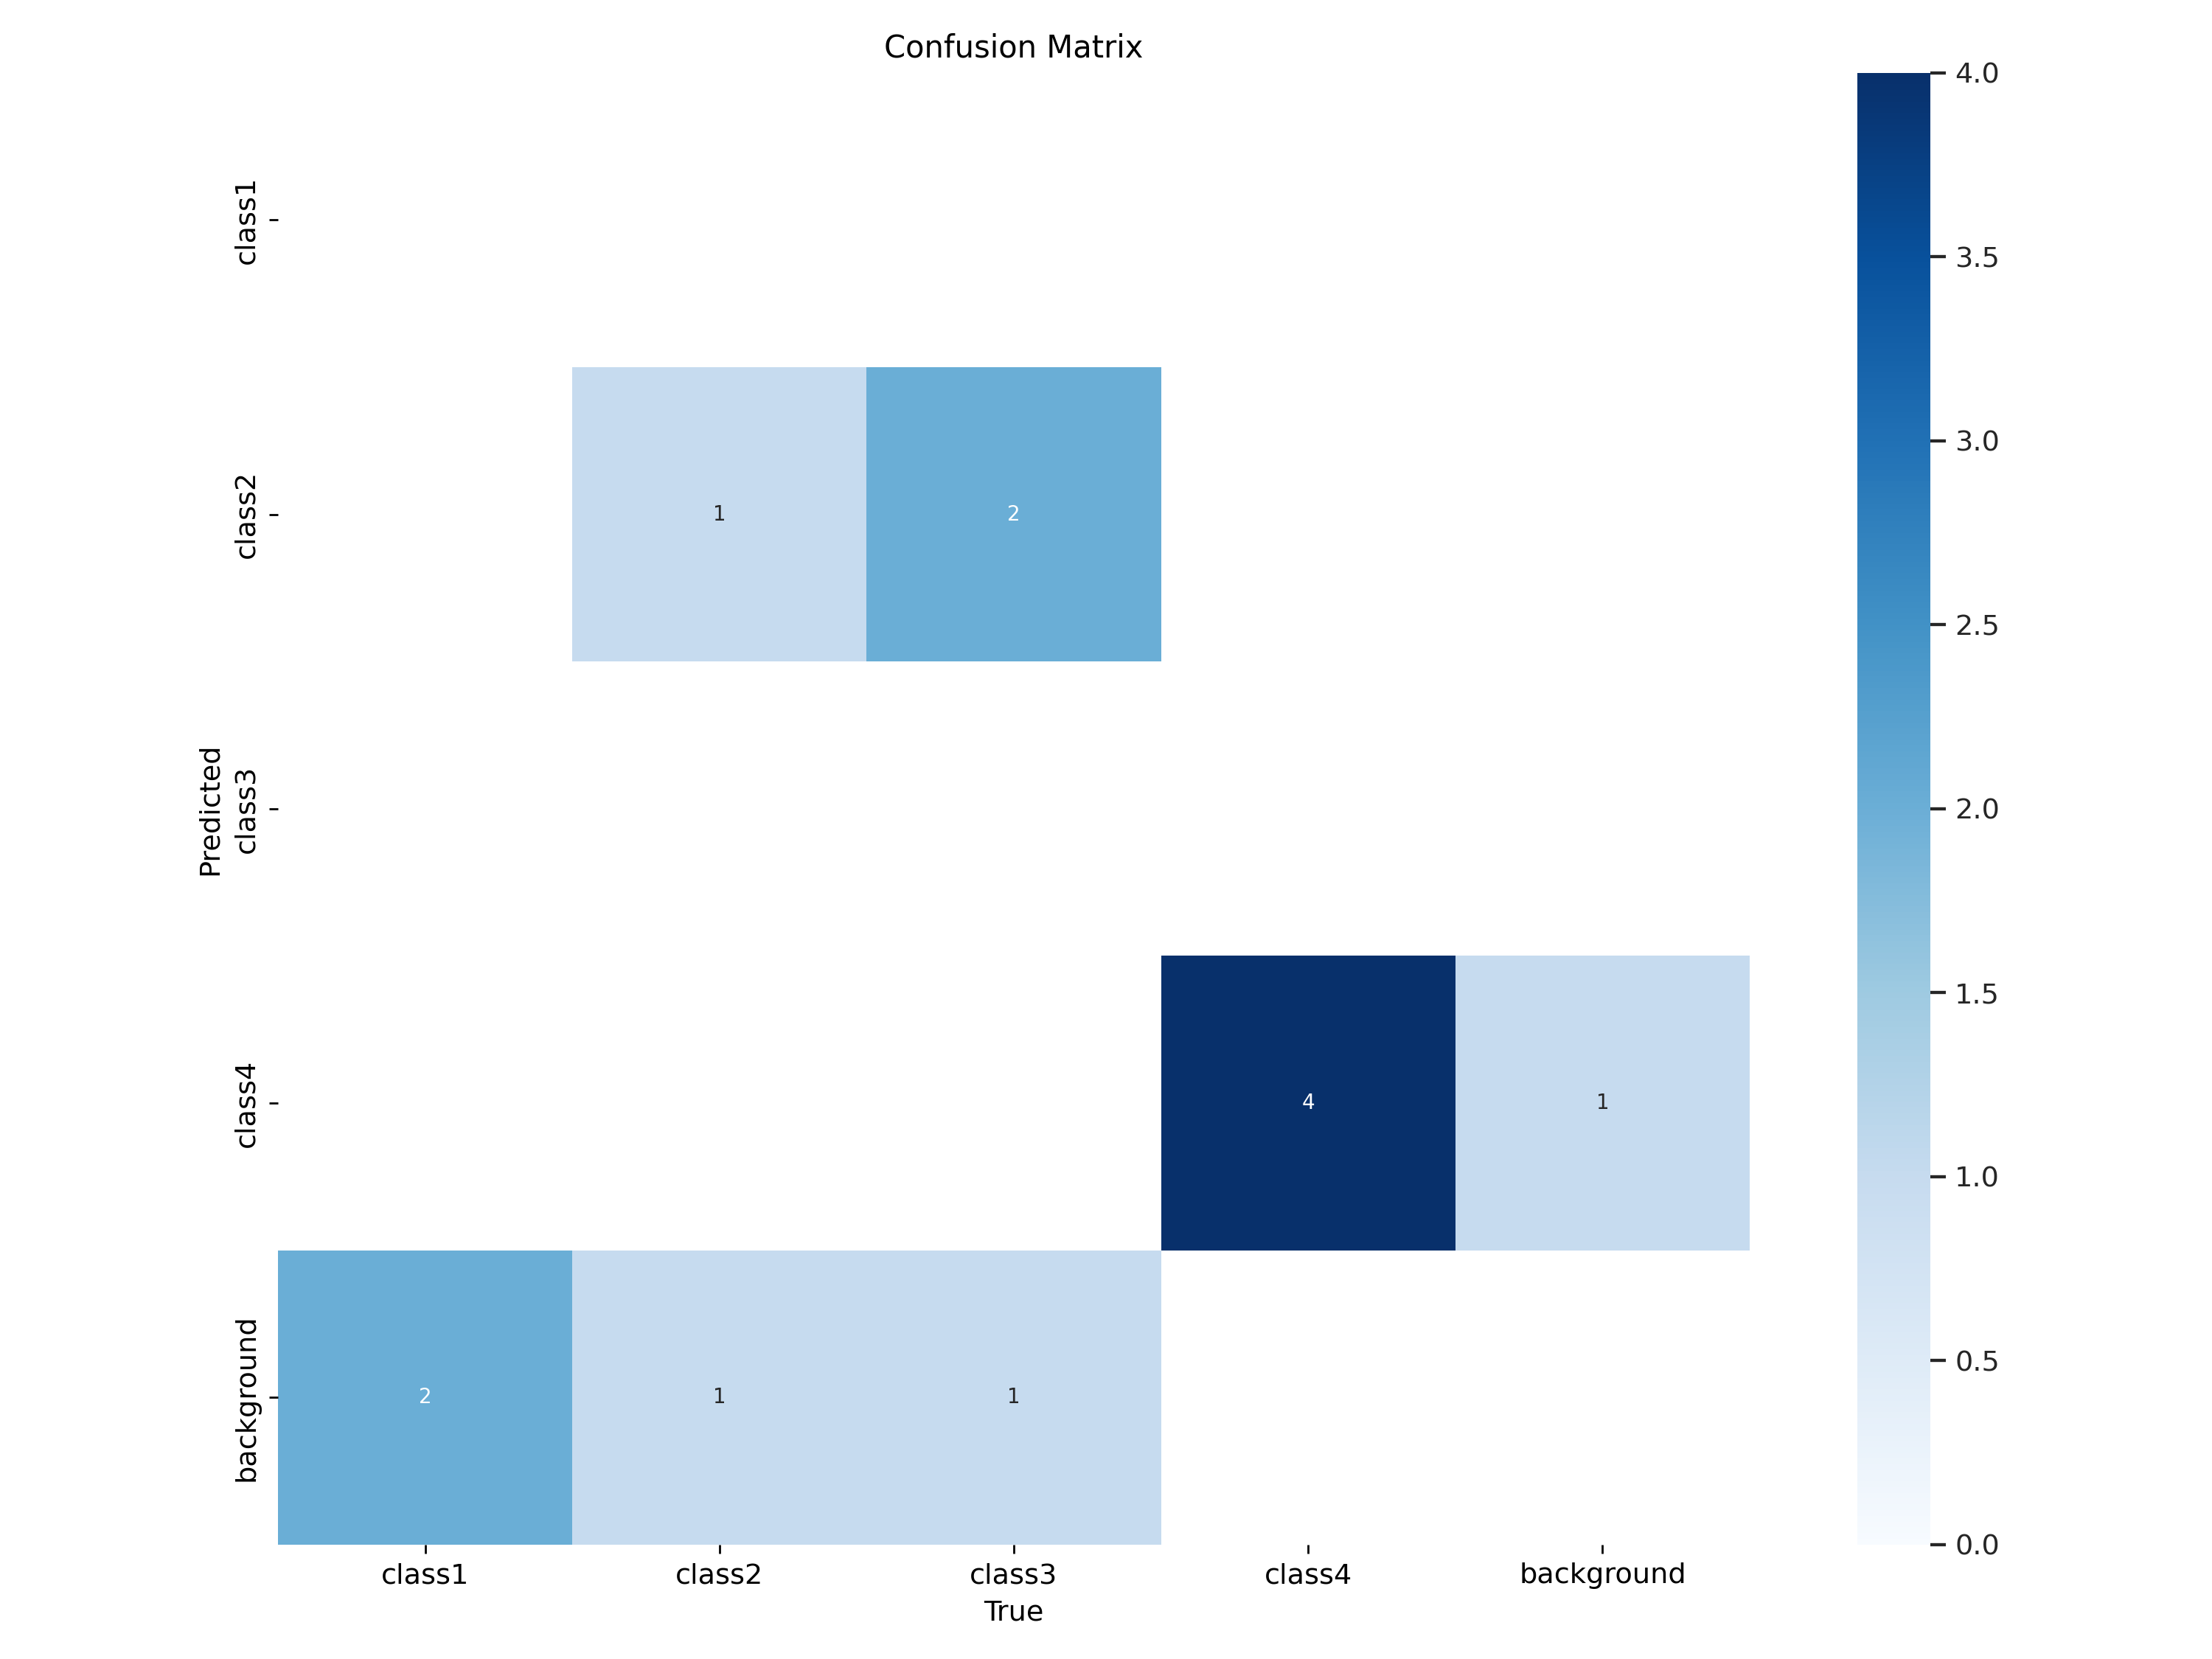

In [12]:
from IPython.display import Image

# 顯示訓練集混淆矩陣
Image(filename=f"/content/runs/detect/train/confusion_matrix.png", width=1000)

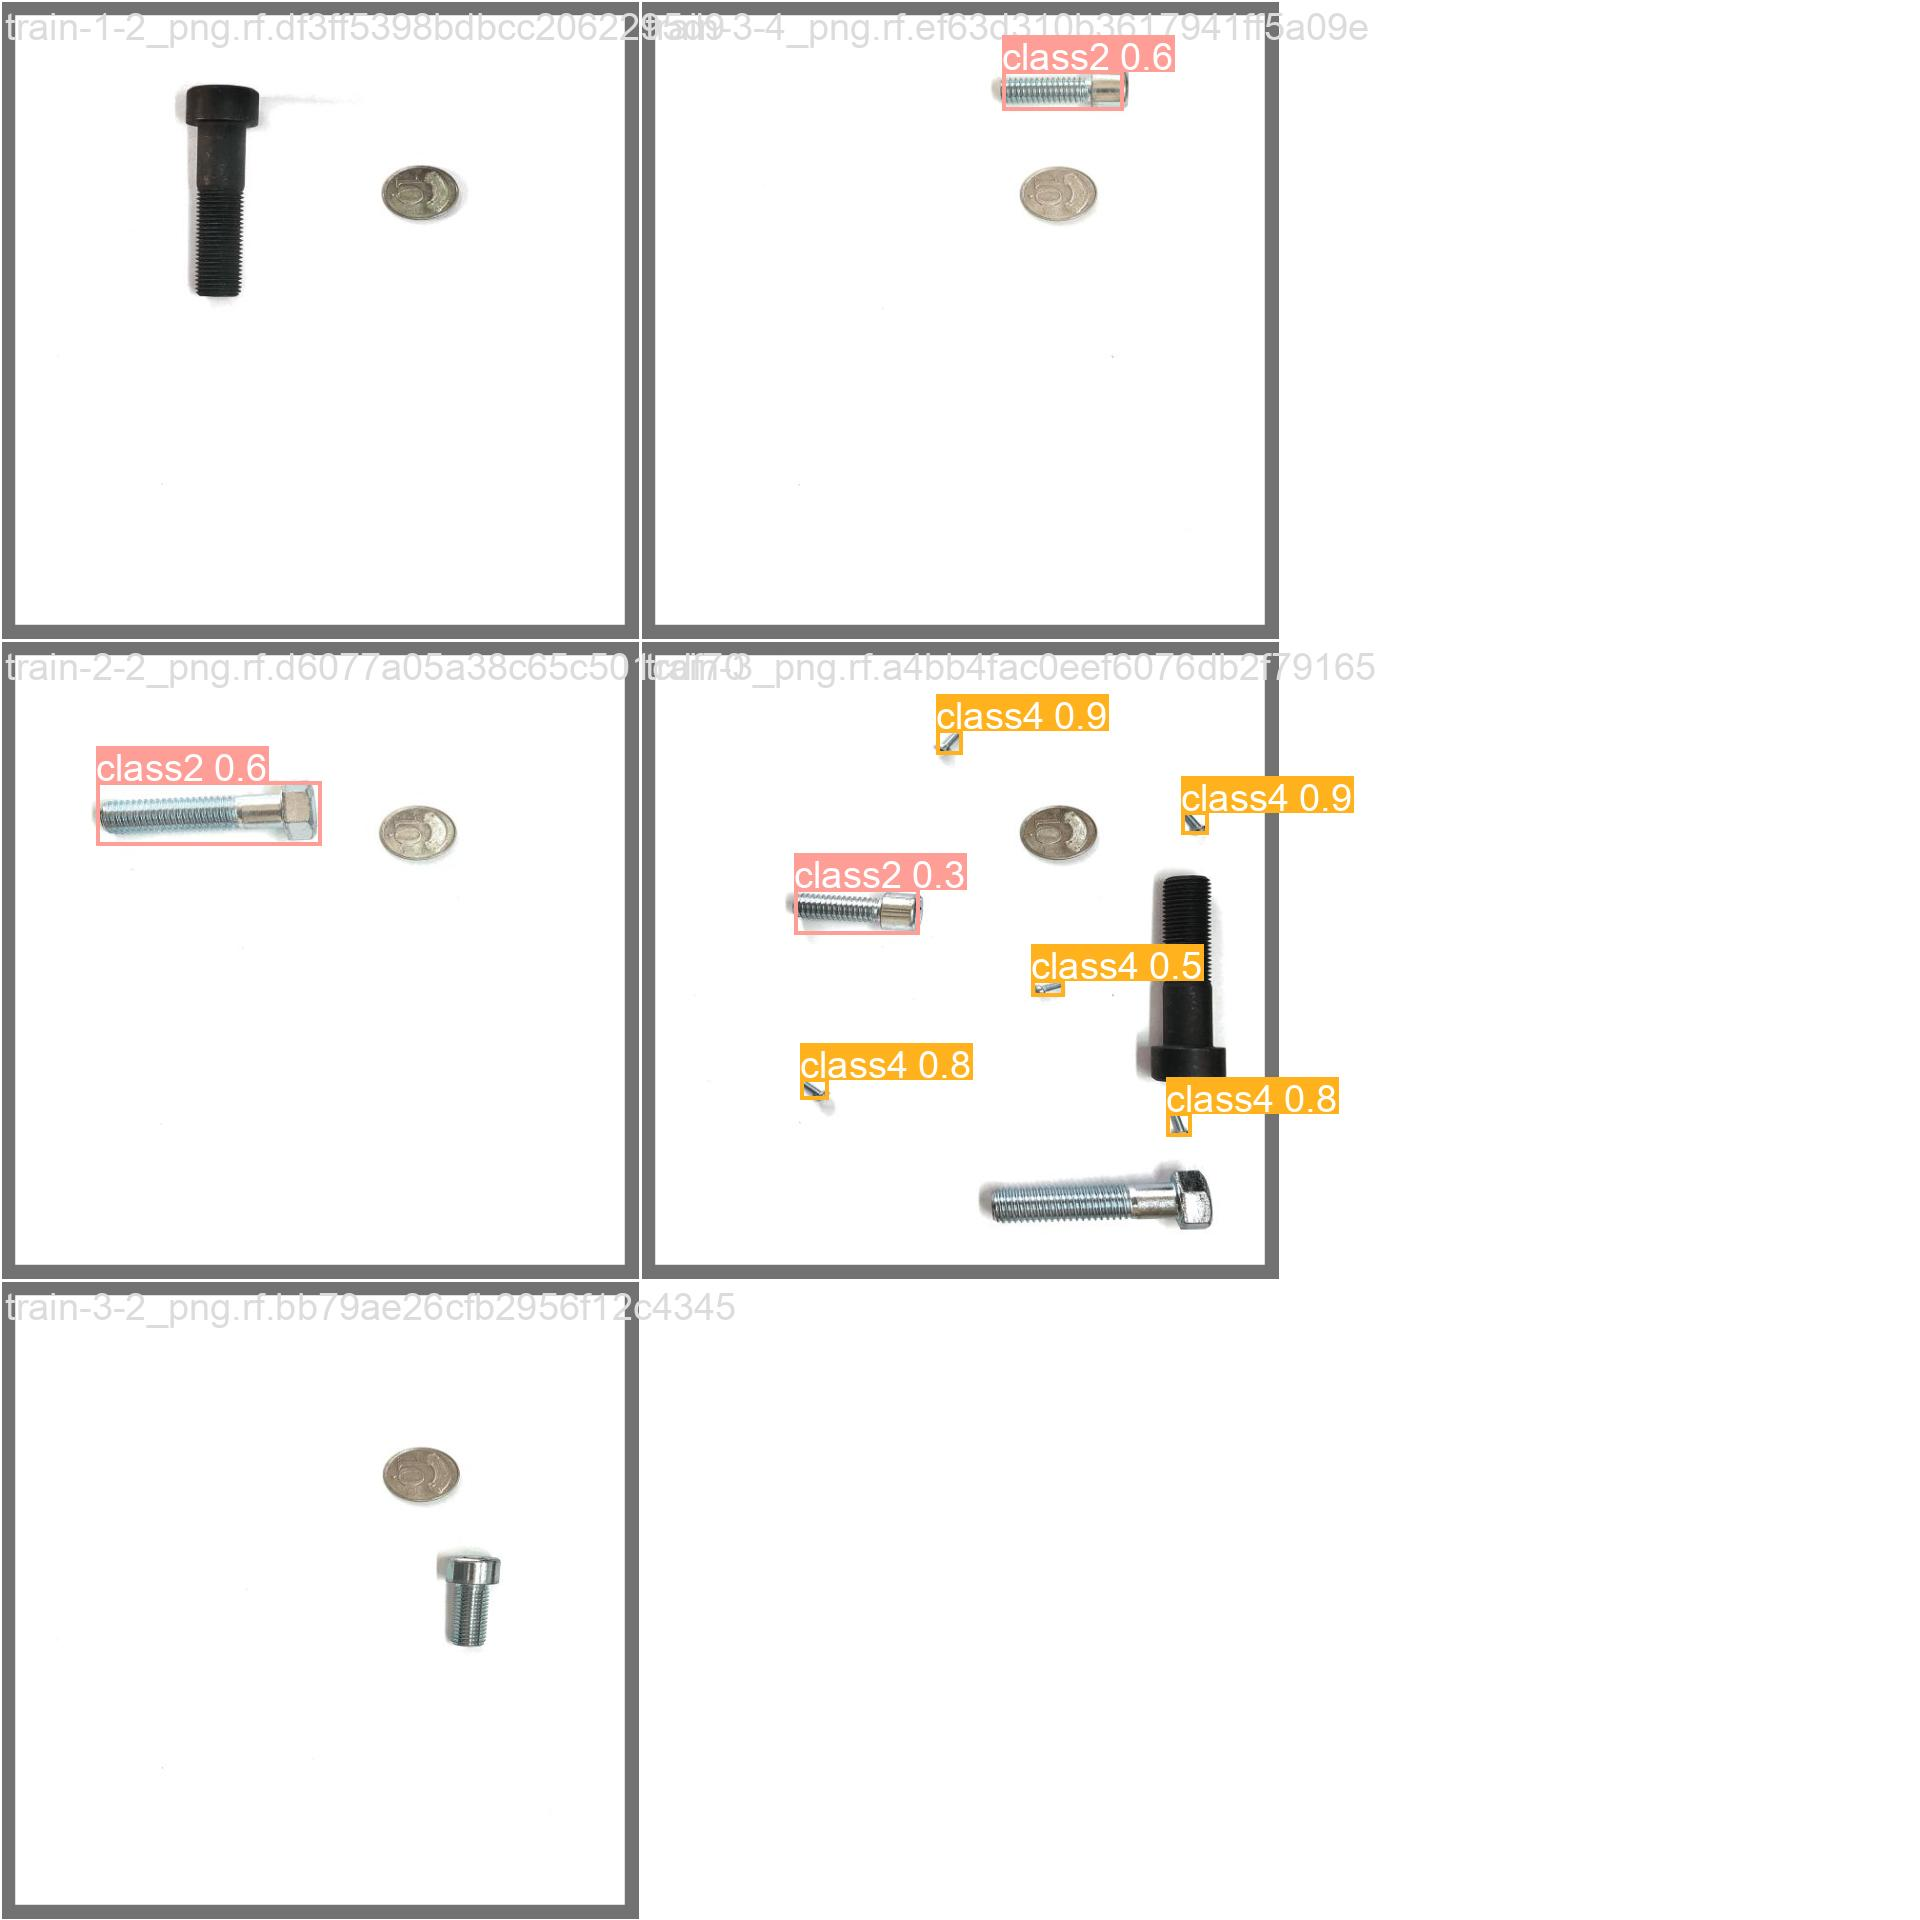

In [13]:
from IPython.display import Image

# 觀察驗證集預測結果
Image(filename=f"/content/runs/detect/train/val_batch0_pred.jpg", width=1000)

### 2.6 測試
### 2.6.1 使用 Ultralytics Python API 預測(方法一)
請注意要使用 ultralytics 的 YOLOv10 API 進行推論，如果使用到 YOLOv8 的函式會出現 `AttributeError: 'dict' object has no attribute 'shape'` 錯誤。

In [14]:
from ultralytics import YOLOv10

model = YOLOv10('/content/runs/detect/train/weights/best.pt')

results = model(f'{dataset.location}/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg', conf=0.25)

print(results[0].boxes.cls)


image 1/1 /content/screw-4/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg: 640x640 1 class2, 5 class4s, 56.1ms
Speed: 1.8ms preprocess, 56.1ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)
tensor([3., 3., 3., 3., 3., 1.], device='cuda:0')


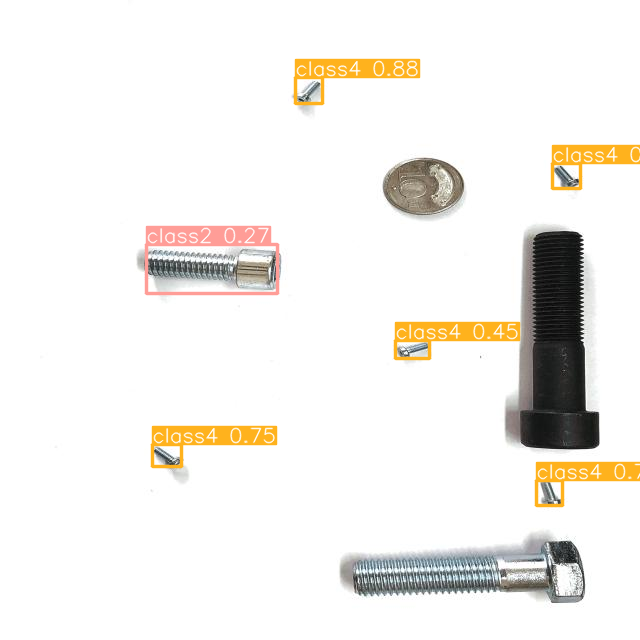

In [15]:
from PIL import Image

r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
# 顯示預測結果
Image.fromarray(im_array[:,:,::-1], 'RGB')

### 使用 supervision 繪製物件框(方法二)
本方法還是使用 Ultralytics Python API 進行預測，但最終物件框繪製採用 supervision 繪製。而方法一是直接拿 ultralytics 內建 API 繪製的結果。

In [16]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [17]:
!pip install -q  supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 1.2 MB/s eta 0:00:00



image 1/1 /content/screw-4/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg: 640x640 1 class2, 5 class4s, 57.6ms
Speed: 4.6ms preprocess, 57.6ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 640)


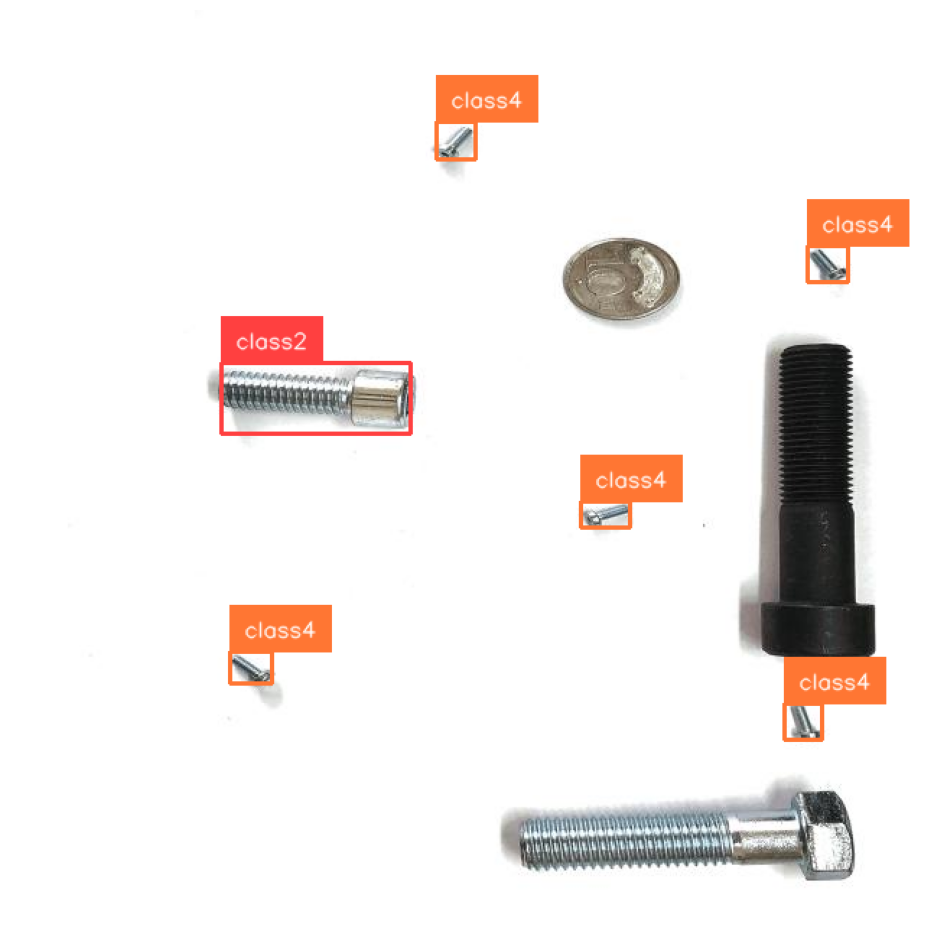

In [18]:
import cv2
import supervision as sv
from ultralytics import YOLOv10

# 設置圖片路徑
image_path = f'{dataset.location}/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg'

# 使用 OpenCV 讀取圖片
input_image = cv2.imread(image_path)
# 執行預測
model = YOLOv10('/content/runs/detect/train/weights/best.pt')
results = model(source=image_path, conf=0.25)[0]
# 為圖片添加邊界框和標籤
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=input_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)
# 顯示預測結果
sv.plot_image(annotated_image)